# 學習日期: 2022/5/21開始
## 目標: 透過LSTM模型，針對"台灣資料集"，預測COVID-19確診人數
- **參考資料1:** https://covid-19.nchc.org.tw/dt_005-covidTable_taiwan.php

## 1_數據分析

In [1]:
import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
#import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim
from sklearn.metrics import r2_score  # R_Score

In [2]:
# dataset -> 數值需為無(千分位,)
df = pd.read_csv('owl_world_taiwan_v1.csv')  # 將csv載入到DataFrame中; usecols=指定載入的行名
print(df.head())

  Taiwan Daily Report by NCHC Unnamed: 1 Unnamed: 2 Unnamed: 3 Unnamed: 4  \
0                          ID   iso_code         洲名         國家         日期   
1                         141        TWN         亞洲         台灣   2022-1-1   
2                         140        TWN         亞洲         台灣   2022-1-2   
3                         139        TWN         亞洲         台灣   2022-1-3   
4                         138        TWN         亞洲         台灣   2022-1-4   

  Unnamed: 5 Unnamed: 6   Unnamed: 7 Unnamed: 8  Unnamed: 9       Unnamed: 10  \
0       總確診數      新增確診數  七天移動平均新增確診數  總確診數/每百萬人  新增確診數/每百萬人  七天移動平均新增確診數/每百萬人   
1      17050         21        22.71     714.74        0.88              0.95   
2      17070         20        22.14     715.57        0.84              0.93   
3      17095         25        23.43     716.62        1.05              0.98   
4      17129         34        25.57     718.05        1.43              1.07   

  Unnamed: 11 Unnamed: 12  
0        總人口數  新聞稿發佈新增

In [3]:
# 抓出資料集的"日期"+"累積確診人數":
# "Date"+"string_data" -> "datetime格式"+"list_data格式"

test = df.iloc[:,4:6 :]  # 切掉不要的行(column_index)
print("Data=\n",test)  # 內容值=0,157841... ;  column_index=2020-1-22... ;  row_index=0,1,2,3
#print("Data=\n",test.values[:,0:2])

isnull = test.isnull().sum().sum()  #檢查缺失值
print("缺失值(NULL)=",isnull)

# dataframe -> np.array
x = test.values[1:,0:1].flatten()  
x = pd.to_datetime(x)  # 時間的智慧轉換
y = test.values[1:,1:2].flatten()

# string -> int
y_list = []
for i in range(len(y)):
    y_list.append(int(y[i]))  
    

print("\n",x[:4])
print("字串需轉為整數:")
print(y[:4])
print(y_list[:4])

Data=
     Unnamed: 4 Unnamed: 5
0           日期       總確診數
1     2022-1-1      17050
2     2022-1-2      17070
3     2022-1-3      17095
4     2022-1-4      17129
..         ...        ...
131  2022-5-11     505455
132  2022-5-12     570870
133  2022-5-13     635870
134  2022-5-14     699824
135  2022-5-15     768543

[136 rows x 2 columns]
缺失值(NULL)= 0

 DatetimeIndex(['2022-01-01', '2022-01-02', '2022-01-03', '2022-01-04'], dtype='datetime64[ns]', freq=None)
字串需轉為整數:
['17050' '17070' '17095' '17129']
[17050, 17070, 17095, 17129]


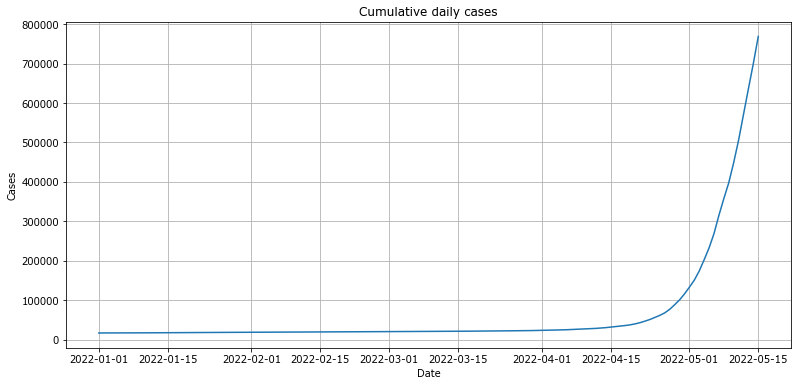

In [12]:
x = x  # 取column index(2020-01)
y = y_list  # 取DataFrame的內容值

plt.figure(figsize=(13,6))
plt.title('Cumulative daily cases')
plt.xlabel("Date")
plt.ylabel("Cases")
plt.plot(x, y_list)
plt.grid()
plt.show()

In [24]:
# 算出"每日確診人數"
# list -> dataframe 
y_dataframe = pd.DataFrame(y_list)  # 為了使用它提供的diff而轉換
print("累積:")
print(y_dataframe)
y_dataframe = y_dataframe.diff()  # 預設是計算每一列做相減
print("\n\n每日:")
print(y_dataframe)
y_dataframe = y_dataframe.fillna(value=21)  # 填充NAN值
print("\n\n每日+NULL填充:")
print(y_dataframe)

累積:
          0
0     17050
1     17070
2     17095
3     17129
4     17155
..      ...
130  505455
131  570870
132  635870
133  699824
134  768543

[135 rows x 1 columns]


每日:
           0
0        NaN
1       20.0
2       25.0
3       34.0
4       26.0
..       ...
130  57132.0
131  65415.0
132  65000.0
133  63954.0
134  68719.0

[135 rows x 1 columns]


每日+NULL填充:
           0
0       21.0
1       20.0
2       25.0
3       34.0
4       26.0
..       ...
130  57132.0
131  65415.0
132  65000.0
133  63954.0
134  68719.0

[135 rows x 1 columns]


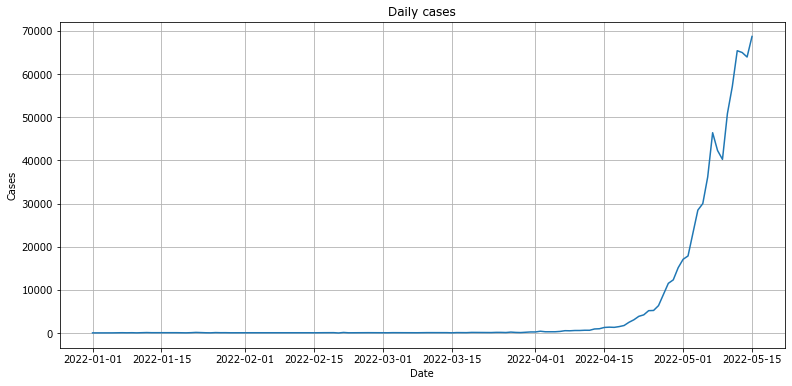

In [26]:
x = x  # 取column index(2020-01)
y = y_dataframe.values  # 取DataFrame的內容值

plt.figure(figsize=(13,6))
plt.title('Daily cases')
plt.xlabel("Date")
plt.ylabel("Cases")
plt.plot(x, y)
plt.grid()
plt.show()

## 2_數據前處理

In [37]:
daily_cases = y_list
print("有", len(y_list),"天的數據")
val_data_size = 14  # 設定切多少天當驗證集
train_data = daily_cases[:-val_data_size]  # 取前面
val_data = daily_cases[len(train_data):]  # 取後面
print("\n訓練集",len(train_data),"天\n預測集",len(val_data),"天")

print("\ntrain_data=\n",train_data)
print("\nval_data=\n",val_data)

有 135 天的數據

訓練集 121 天
預測集 14 天

train_data=
 [17050, 17070, 17095, 17129, 17155, 17198, 17258, 17302, 17362, 17393, 17463, 17559, 17624, 17692, 17769, 17820, 17885, 17951, 18005, 18041, 18109, 18239, 18325, 18376, 18411, 18503, 18566, 18634, 18681, 18735, 18790, 18850, 18903, 18958, 19029, 19101, 19144, 19192, 19239, 19293, 19376, 19455, 19515, 19567, 19621, 19666, 19732, 19797, 19864, 19937, 19937, 20056, 20100, 20156, 20236, 20304, 20373, 20433, 20489, 20533, 20582, 20653, 20717, 20797, 20840, 20869, 20922, 20999, 21081, 21163, 21225, 21288, 21363, 21402, 21492, 21583, 21658, 21784, 21905, 22003, 22091, 22188, 22327, 22463, 22566, 22769, 22896, 22992, 23155, 23393, 23629, 24033, 24312, 24585, 24866, 25225, 25756, 26263, 26836, 27410, 28040, 28666, 29593, 30574, 31857, 33205, 34507, 35983, 37710, 40186, 43243, 47100, 51298, 56468, 61686, 68022, 76938, 88446, 100753, 115883, 132955]

val_data=
 [150808, 173942, 202418, 232402, 268569, 314983, 357271, 397504, 448323, 505455, 570870, 635